# Sentiment Analytics of Twitter using ULMFiT



## Problem Description

A sentiment analysis job has to be done regarding the problems of each major U.S. airline and contributors. We have to first classify positive, negative and neutral tweets, and then categorize the negative tweets into "late flight" or "rude service".  https://www.kaggle.com/crowdflower/twitter-airline-sentiment

We will apply a  supervised or semi-supervised ULMFiT model to the Twitter US Airlines Sentiment by following the ULMFiT approach of Howard, and Ruder described in the paper: https://arxiv.org/pdf/1801.06146.pdf.

### Importing the libraries

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
import re
import sklearn
from fastai.metrics import accuracy
from fastai.text import *
from fastai import *


## Preprocessing of Data

### Importing the dataset

In [88]:
dat = pd.read_csv('Tweets.csv')

In [89]:
dat.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Handling the missing values

Identification of missing values will enable us to identify unnecessary columns in the data.

The which column which has maximum number of null values will be treated as unnecessary.

In [30]:
print("Null Values", dat.isna().sum())

Null Values tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


The features tweet_coord , airline_sentiment_gold, negativereason_gold has maximum missing values. So, we have to drop these features

In [42]:
dat.drop(["tweet_coord", "airline_sentiment_gold", "negativereason_gold"],axis=1, inplace = True)

### Visualization of Dataset

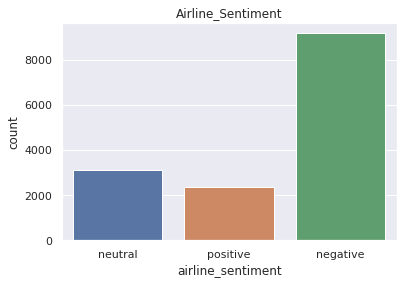

In [32]:
sns.set()
sns.countplot(x=dat["airline_sentiment"])
plt.title("Airline_Sentiment")
plt.show()

Highest count of the comments are negative is visible.

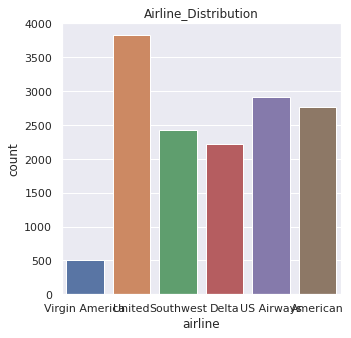

In [14]:
sns.set()
plt.figure(figsize=(5,5))
sns.countplot(x=dat["airline"])
plt.title("Airline_Distribution")
plt.show()

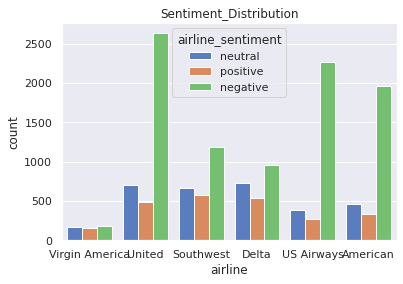

In [15]:
sns.set()
plt.figure()
sns.countplot(x=dataset["airline"], hue=dataset["airline_sentiment"])
plt.title("Sentiment_Distribution")
plt.show()

Virgin America has most positive response, while is United has the most negative response from customers.

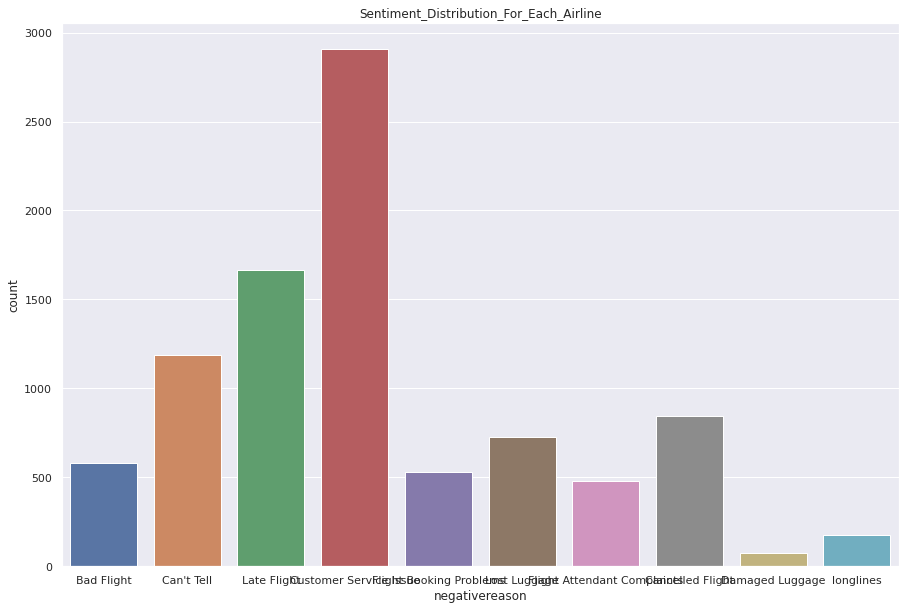

In [18]:
sns.set()
plt.figure(figsize=(15,10))
#plt.figure()
sns.countplot(x=dataset["negativereason"])
plt.title("Sentiment_Distribution_For_Each_Airline")
plt.show()

The most common reason for any negative tweet is the bad customer service offered by the airline.

In [43]:
sn = dat[['airline_sentiment','text']]
sn.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


We need to clean the column text.Text cleaning can be done by:
1. Removing characters apart from A-Z and a-z.
2. Converting all the characters in Lowercase.
3. Replace 'https://' with 'url' 



In [45]:

tweets = []
for i in range(0, len(sn)):
    txt= re.sub('[^a-zA-Z]', ' ', sn['text'][i])
    txt = txt.lower()
    txt = re.sub(r'#([^\s]+)', r'\1', sn['text'][i])
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','link',sn['text'][i])
    tweets.append(txt)
    

In [46]:
sn['cleaned_tweets']= tweets
sn.drop(["text"],axis=1, inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [47]:
sn

,airline_sentiment,cleaned_tweets
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


### Splitting the dataset

We will only use the two columns that are 'cleaned_tweets' and 'airline_sentiment' and create new_df.

In [49]:
new_df = sn[['cleaned_tweets','airline_sentiment']]
new_df

,cleaned_tweets,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


Training set= 80%

Testing set= 20% 

In [51]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(new_df,test_size=0.2,random_state=5)

In [52]:
df_train.to_csv('twitter_train.csv')
df_test.to_csv('twitter_test.csv')

## ULMFiT Model Building

### Build the Language Model

We will use TextDataBunch for training the language model.

Validation set will be 10%

In [53]:
tweet = TextLMDataBunch.from_csv(path='',csv_name='twitter_train.csv',valid_pct=0.1)


For building the language model, we use language_model_learner() from fastai. We will use AWD_LSTM architecture for our language model.


In [54]:
model = language_model_learner(tweet, AWD_LSTM, drop_mult=0.3)


We use learning rate find to identify the optimum learning rate.

In [55]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


If we pass suggestion=True in the learn.recorder.plot(), we can obtain the point where the gradient is the steepest. It is indicated with a red dot on the graph. We can use that point as the first guess for our Learning Rate.

Min numerical gradient: 4.79E-02
Min loss divided by 10: 6.31E-02


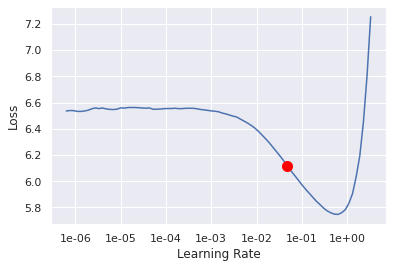

In [57]:
model.recorder.plot(suggestion=True)

As evident from the graph plotted above, we will take 1e-01  as the learning rate since approximately after that the loss starts minimizing.


In [58]:
model.fit_one_cycle(cyc_len=1,max_lr=1e-01,moms=(0.80,0.70))

epoch,train_loss,valid_loss,accuracy,time
0,4.582178,4.056767,0.258578,00:08


Unfreezing the LSTM layers of the model

In [59]:
model.unfreeze()

In [60]:
model.fit_one_cycle(cyc_len=6, max_lr=slice(1e-01/(2.6),3.98e-02), moms=(0.80, 0.70))

epoch,train_loss,valid_loss,accuracy,time
0,3.905700,4.013437,0.256154,00:11
1,4.001692,4.061870,0.250638,00:11
2,3.944696,3.988710,0.262787,00:11
3,3.759400,3.907560,0.273087,00:11
4,3.437469,3.903363,0.279082,00:12
5,2.985248,3.987890,0.277264,00:12


In [61]:
model.save_encoder('encoder')

### Classification Language Model Building

In [67]:
tweet_classfier = TextClasDataBunch.from_csv(path='',csv_name='twitter_train.csv',
                              vocab=tweet.train_ds.vocab,bs=32,text_cols='cleaned_tweets',label_cols='airline_sentiment')


By using 'text_classifier_learner' we will create a learner object. 

In [71]:
learn_model = text_classifier_learner(tweet_classfier, AWD_LSTM, drop_mult=0.5)

Then we will load the encoder into this object i.e learner

In [72]:
learn_model.load_encoder('encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9369 items)
x: TextList
xxbos @southwestair up at xxup 4am and arrive to find it already xxmaj cancelled xxmaj flighted . xxmaj no options so miss my meeting . xxmaj you might " know " but do n't show it .,xxbos @united , xxmaj understandable . i did try xxmaj flight xxmaj booking xxmaj problems several times for 2 passengers & & got the messages i mentioned before . xxmaj as for the agents price ? ? ?,xxbos @united left my ipad on xxup xxunk flight 174 . xxmaj how long to hear back once claim submitted ? xxup ty !,xxbos @americanair you xxmaj cancelled xxmaj flight both flights yesterday and rebook me in middle seat . xxmaj not acceptable . xxmaj upgrade to emergency row would help . nothappy,xxbos @united xxmaj do we know why xxup xxunk is delayed x2 ) ? xxmaj this is getting crazy . i 've already had 2 overnight delays . unitedairlines
y: CategoryList
negative,neutral,neutral,negative,negative
Path: .;

Valid: LabelList (2343 ite


We will peform Gradual Unfreezing to prevent the model from forgetting the features.

In [73]:
learn_model.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-03
Min loss divided by 10: 1.74E-02


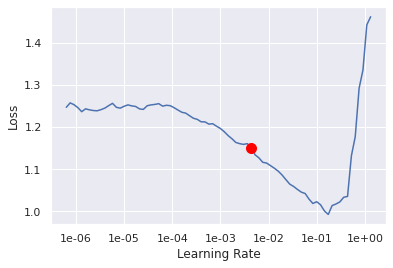

In [75]:
learn_model.recorder.plot(suggestion=True)

Similarly, how we did before, we choose a learning rate (optimized one) before the graph starts descending and reaches a minimum. Along with it, we will use the one cycle policy.

In [76]:
learn_model.fit_one_cycle(6,4.37E-03,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.696083,0.570879,0.780196,00:06
1,0.608190,0.531523,0.787025,00:06
2,0.598295,0.526299,0.793000,00:06
3,0.580342,0.529145,0.793854,00:06
4,0.573895,0.519830,0.799402,00:06
5,0.534017,0.517458,0.804097,00:06


We need to Unfreeze next layer.

In [77]:
learn_model.freeze_to(-2)

Rather than using the same learning rate for all layers, we will use discriminative for fine-tuning which enables us to apply specific learning rates to the layers of our neural network.


In [78]:
learn_model.fit_one_cycle(6,slice(4.37E-03/(2.6),4.37E-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.545659,0.506306,0.801110,00:07
1,0.543679,0.505273,0.801537,00:07
2,0.530995,0.507562,0.811780,00:07
3,0.422513,0.508244,0.806231,00:07
4,0.348320,0.526361,0.805805,00:07
5,0.302408,0.531634,0.809646,00:07


Now we will repeat the process with next layer.

In [79]:
learn_model.freeze_to(-3)
learn_model.fit_one_cycle(6,slice(4.37E-03/(2.6),4.37E-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.339741,0.553870,0.810499,00:11
1,0.388957,0.554531,0.809646,00:11
2,0.319234,0.601407,0.801537,00:11
3,0.264641,0.587914,0.813487,00:11
4,0.183766,0.637854,0.812633,00:12
5,0.142150,0.648458,0.817328,00:11


We will unfreeze all the layers.

In [80]:
learn_model.unfreeze()
learn_model.fit_one_cycle(6,slice(4.37E-03/(2.6),4.37E-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.158934,0.701993,0.809646,00:14
1,0.254960,0.647828,0.810926,00:14
2,0.246263,0.662258,0.805378,00:15
3,0.173739,0.666034,0.809219,00:16
4,0.141224,0.715210,0.814767,00:14
5,0.109072,0.724438,0.816901,00:15


## Prediction 

In [81]:
test_tweet = pd.read_csv('twitter_test.csv')
print(test_tweet[['cleaned_tweets','airline_sentiment']])

                                         cleaned_tweets airline_sentiment
0     @VirginAmerica has getaway deals through May, ...          positive
1     @USAirways Thanks but when I asked for a chang...          negative
2                     @united maybe on my return trip 👍          positive
3     @JetBlue no I asked. Either way it doesn't mak...          negative
4     @SouthwestAir Totally ruined my birthday weeke...          negative
...                                                 ...               ...
2923  @united next flight? Don't think I'll be spend...          negative
2924  @AmericanAir @GolfWithWoody Don't buy it, Wood...          negative
2925  @AmericanAir Cancelled Flight my flight saying...          negative
2926  @SouthwestAir thanks to Ella-Mae at LAS counte...          positive
2927  @USAirways reservations had me on hold for 2 h...          negative

[2928 rows x 2 columns]


In [82]:
test_tweet.head()

,Unnamed: 0,cleaned_tweets,airline_sentiment
0,111,"@VirginAmerica has getaway deals through May, ...",positive
1,9369,@USAirways Thanks but when I asked for a chang...,negative
2,3113,@united maybe on my return trip 👍,positive
3,7235,@JetBlue no I asked. Either way it doesn't mak...,negative
4,5002,@SouthwestAir Totally ruined my birthday weeke...,negative


### Prediction of new Tweets

We will append a new column for displayig the predicted values.

In [84]:
test_tweet['predicted_airline_sentiments'] = test_tweet['cleaned_tweets'].apply(lambda row:str(learn_model.predict(row)[0]))

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


In [87]:
print("Model Accuracy- {}".format(accuracy_score(test_tweet['airline_sentiment'],test_tweet[
    'predicted_airline_sentiments'])))

Model Accuracy- 0.8189890710382514


## Conclusion


The final accuracy obtained by our ULMFiT model is 81.9 percent(which is very good accuracy.)